In [25]:
import glob
import nibabel as nib
from nibabel.orientations import axcodes2ornt, ornt_transform, apply_orientation, ornt2axcodes
import ipympl
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from lito_radiomics.lito_radiomics.lito_features import shape2D
from cupyx.scipy import ndimage
from radiomics import featureextractor
import SimpleITK as sitk
from skimage.measure import EllipseModel, find_contours
from skimage.draw import ellipse
from scipy import spatial
import scipy

In [26]:
def compute_dice_ellipse(a, b, eigen_vect, mask_slice):
    
    angle1 = np.arctan(eigen_vect[1][1]/eigen_vect[1][0])
    angle2 = np.arctan(eigen_vect[1][1]/eigen_vect[1][0]) + np.deg2rad(90)

    center = ndimage.center_of_mass(cp.asarray(sitk.GetArrayFromImage(mask_slice)))
    xy1 = EllipseModel().predict_xy(np.linspace(0, 2 * np.pi, 25), params=(center[1].item(), center[0].item(), a, b, angle1))
    xy2 = EllipseModel().predict_xy(np.linspace(0, 2 * np.pi, 25), params=(center[1].item(), center[0].item(), a, b, angle2))
    ell1 = ellipse(center[1].item(), center[0].item(), a, b, rotation=angle1)
    ell2 = ellipse(center[1].item(), center[0].item(), a, b, rotation=angle2)

    contours = find_contours(sitk.GetArrayFromImage(mask_slice), 0.5)
    contours = [np.flip(contours[k]) for k in range(len(contours))]

    ellipse_estimation = EllipseModel()
    if ellipse_estimation.estimate(xy1):
        residuals1 = np.mean(np.concatenate([ellipse_estimation.residuals(contours[k]) for k in range(len(contours))]))
        
    if ellipse_estimation.estimate(xy2):
        residuals2 = np.mean(np.concatenate([ellipse_estimation.residuals(contours[k]) for k in range(len(contours))]))
        
    shape_slice = sitk.GetArrayFromImage(mask_slice).shape
    mask_ellipse1 = np.zeros(shape_slice)
    mask_ellipse1[[i for (i, j) in zip(ell1[::-1][0], ell1[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])], [j for (i, j) in zip(ell1[::-1][0], ell1[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])]] = 1

    mask_ellipse2 = np.zeros(shape_slice)
    mask_ellipse2[[i for (i, j) in zip(ell2[::-1][0], ell2[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])], [j for (i, j) in zip(ell2[::-1][0], ell2[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])]] = 1

    dice1=1-spatial.distance.dice(sitk.GetArrayFromImage(mask_slice).ravel(), mask_ellipse1.ravel())
    dice2=1-spatial.distance.dice(sitk.GetArrayFromImage(mask_slice).ravel(), mask_ellipse2.ravel())

    if dice1 >= dice2:
        return residuals1, dice1, xy1, mask_ellipse1, center
    else:
        return residuals2, dice2, xy2, mask_ellipse2, center

In [27]:
def check_orientation(ct_image, ct_arr):
    """
    Check the NIfTI orientation, and flip to  'LPS' if needed.
    :param ct_image: NIfTI file
    :param ct_arr: array file
    :return: array after flipping
    """

    original_ornt = nib.orientations.io_orientation(ct_image.affine)
    print(ornt2axcodes(original_ornt))
    rai_ornt = axcodes2ornt(('L', 'P', 'S'))
    transform = ornt_transform(original_ornt, rai_ornt)
    ct_arr = np.rot90(apply_orientation(ct_arr, transform), axes=(0,2), k=1)
    return ct_arr

In [28]:
def display_MIP(a_im, a_bb, a_ma):
    mip_ax=  np.max(np.array(a_im), axis=0)
    mip_cor= np.max(np.array(a_im), axis=1)
    mip_sag= np.max(np.array(a_im), axis=2)

    mip_ax_bb=  np.max(np.array(a_bb), axis=0)
    mip_cor_bb= np.max(np.array(a_bb), axis=1)
    mip_sag_bb= np.max(np.array(a_bb), axis=2)

    mip_ax_mask=  np.max(np.array(a_ma), axis=0)
    mip_cor_mask= np.max(np.array(a_ma), axis=1)
    mip_sag_mask= np.max(np.array(a_ma), axis=2)

    plt.close('all')


    _, axs = plt.subplots(1, 3, figsize=(10, 8))
    for img, ma, ax in zip([mip_ax, mip_sag, mip_cor], [mip_ax_mask, mip_sag_mask, mip_cor_mask], axs):
        ax.imshow(img, cmap='grey', vmin=np.min(np.array(a_im)), vmax=np.max(np.array(a_im)))
        ax.imshow(ma, alpha=0.25*(ma>0))
    plt.show()

In [29]:
def remove_out_of_box_mask(mask, box):
    _, y, z = np.where(~box.mask)
    y_min = y.min()
    y_max = y.max()
    z_min = z.min()
    z_max = z.max()
    
    y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
    y_max_iso = int(y_max - (y_max-y_min)/2 + 25)
    z_min_iso = int(z_max - (z_max-z_min)/2 - 25)
    z_max_iso = int(z_max - (z_max-z_min)/2 + 25)


    mask[:, :y_min_iso, :] = mask[:, y_max_iso+1:, :] = mask[:, :, :z_min_iso] = mask[:, :, z_max_iso+1:] = 0
    
    return mask
    

In [30]:
def resegment_thresholding(image, mask, thresh=0.2):
    
    max = (image*mask).max()
    print(thresh*max)
    new_mask20= np.ma.masked_where((image*mask) > thresh*max, mask)

    return new_mask20.mask.astype(float)

In [31]:
def standardize_roi(image, mask, desired_area):

    # Calculate the current area of the ROI
    current_area = cp.sum(mask)
    print(current_area)
    # Calculate the scaling factor
    scale_factor = cp.sqrt(desired_area / current_area)
    print(f'mask {str(mask.shape[0])} {str(mask.shape[1])} {str(scale_factor)}')
    
    return ndimage.zoom(cp.array(image), scale_factor), ndimage.zoom(cp.array(mask), scale_factor, order=0)


In [32]:
def _extracted_from_features_extraction2D_4(arg0, cut, data_spacing):
    result = sitk.GetImageFromArray(arg0[int(cut), :, :])
    result.SetSpacing(
        (
            float(data_spacing[0]),
            float(data_spacing[1]),
            float(data_spacing[2]),
        )
    )
    result = sitk.JoinSeries(result)

    return result

In [33]:
def ellipse_perimeter(a, b):
    """
    Compute the perimeter of an ellipse using Ramanujan's approximation formula.
    
    Parameters:
        a (float): Length of the semi-major axis.
        b (float): Length of the semi-minor axis.
    
    Returns:
        float: Perimeter of the ellipse.
    """
    h = ((a - b) / (a + b))**2
    perimeter = np.pi * (a + b) * (1 + (3 * h) / (10 + np.sqrt(4 - 3 * h)))
    return perimeter

In [34]:
def fill_holes(mask):
    filled_mask = scipy.ndimage.binary_fill_holes(mask[0, :, :]).astype(float)
    return filled_mask

In [35]:
def for_ellipse_creation(features_extractor, image, mask):
    results = features_extractor.execute(image, mask)
    features_lito = shape2D.LitoRadiomicsShape2D(image, mask)
    features_eigenvect = features_lito.getEigenVectorsFeatureValue()
    
    a = float(results['original_shape2D_MajorAxisLength'])/2  # Semi-major axis
    b = float(results['original_shape2D_MinorAxisLength'])/2  # Semi-minor axis
    perimeter = ellipse_perimeter(a, b)
    real_perimeter = float(results['original_shape2D_Perimeter'])
    ellipticity = perimeter/real_perimeter
    
    return results, features_eigenvect, a, b, ellipticity

In [36]:
# TODO Rename this here and in `features_extraction2D`
def _extracted_from_features_extraction2D_11():
    result = featureextractor.RadiomicsFeatureExtractor(force2D=True)
    result.disableAllFeatures()
    result.enableFeaturesByName(
        shape2D=[
            "PerimeterSurfaceRatio",
            "Sphericity",
            "MajorAxisLength",
            "MinorAxisLength",
            "Perimeter",
        ]
    )

    return result

In [37]:
def features_extraction2D(a_im, a_ma, cut, filled=True):

    data_spacing = [1,1,1]
    sitk_img = _extracted_from_features_extraction2D_4(a_im, cut, data_spacing)
    sitk_mask = _extracted_from_features_extraction2D_4(a_ma, cut, data_spacing)
    sitk_mask = sitk.Cast(sitk_mask, sitk.sitkInt32)

    if filled is True:
        sitk_mask = sitk.GetImageFromArray(fill_holes(sitk.GetArrayFromImage(sitk_mask)))
    resized_image, resized_mask = standardize_roi(sitk.GetArrayFromImage(sitk_img), sitk.GetArrayFromImage(sitk_mask), 1250)
    resized_image = sitk.GetImageFromArray(cp.asnumpy(resized_image))
    resized_mask = sitk.GetImageFromArray(cp.asnumpy(resized_mask))
    features_40_slice = _extracted_from_features_extraction2D_11()
    features_40_slice_resized = _extracted_from_features_extraction2D_11()
    try:
        image = sitk_img[:, :, 0] if filled is True else sitk_img
        resized_image = resized_image[:, :, 0] if filled is True else resized_image
        results, features_eigenvect, a, b, ellipticity = for_ellipse_creation(features_40_slice, image, sitk_mask)
        results_resized, features_eigenvect_resized, a_resized, b_resized, _ = for_ellipse_creation(features_40_slice_resized, resized_image, resized_mask)
    
        res, di, cont_ellipse, mask_ell, center = compute_dice_ellipse(a, b, features_eigenvect, sitk_mask)
        _, di_resized, _, _, _ = compute_dice_ellipse(a_resized, b_resized, features_eigenvect_resized, resized_mask)
        
        return ellipticity, float(results['original_shape2D_PerimeterSurfaceRatio']), float(results['original_shape2D_Sphericity']), res, di, di_resized, cont_ellipse, mask_ell, center

    except ValueError:
        return None, None, None, None, None, None, None, None




/mnt/data/psteinmetz/neotex/to_process/136
('R', 'A', 'I')
('R', 'A', 'I')
('R', 'A', 'I')
0.5707705249864853


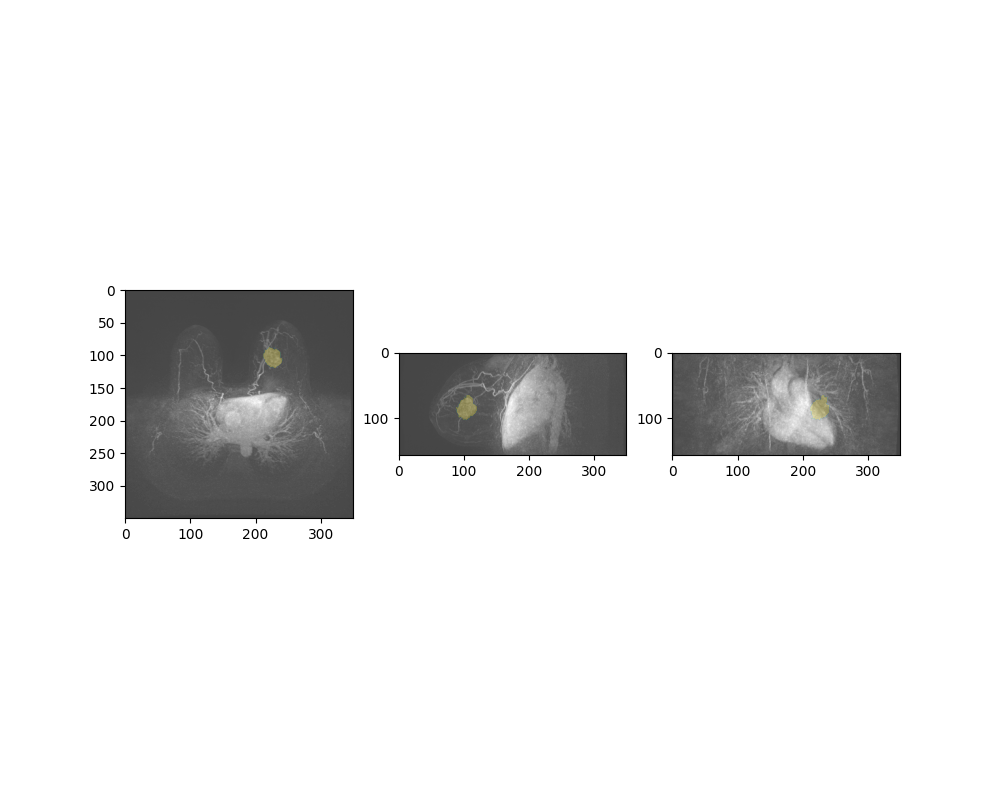

48.0
mask 350 350 5.103103630798288
72.0
mask 350 350 4.166666666666667
87.0
mask 350 350 3.790490217894517
98.0
mask 350 350 3.5714285714285716
135.0
mask 350 350 3.042903097250923
178.0
mask 350 350 2.6499947000159
220.0
mask 350 350 2.3836564731139807
257.0
mask 350 350 2.2054054569561545
279.0
mask 350 350 2.1166687833365083
317.0
mask 350 350 1.985753676973844
400.0
mask 350 350 1.7677669529663689
476.0
mask 350 350 1.620509308880411
535.0
mask 350 350 1.5285446012893575
586.0
mask 350 350 1.460515594592465
613.0
mask 350 350 1.4279886949438496
635.0
mask 350 350 1.4030338331657843
630.0
mask 350 350 1.4085904245475276
622.0
mask 350 350 1.4176199428093568
599.0
mask 350 350 1.444579991642469
576.0
mask 350 350 1.473139127471974
558.0
mask 350 350 1.4967108502231241
527.0
mask 350 350 1.5401027590842435
455.0
mask 350 350 1.6574838603294897
457.0
mask 350 350 1.6538530041390562
420.0
mask 350 350 1.7251638983558855
389.0
mask 350 350 1.7925868484551868
347.0
mask 350 350 1.8979740

In [38]:
path_data = glob.glob("/mnt/data/psteinmetz/neotex/to_process/*")
for data in path_data:
    print(data)
    image_path_sub = glob.glob(
        f'{data}/RawVolume/substracted_resampled_bspline_zscore_without_tumor.nii.gz'
    )

    mask_path = glob.glob(f'{data}/RoiVolume/New_C1_volume_resampled_NN.nii.gz')
    bb_path = glob.glob(f'{data}/RoiVolume/New_bb_resampled_NN.nii.gz')
    if image_path_sub == []:
        print('problem image')
        pass
    elif mask_path == [] or bb_path == []:
        print('problem mask')
        pass
    else:
        image_sub = nib.load(image_path_sub[0])
        mask_bb = nib.load(bb_path[0])
        mask = nib.load(mask_path[0])
        
        image_sub = check_orientation(image_sub, np.array(image_sub.dataobj))
        mask_bb = check_orientation(mask_bb, np.array(mask_bb.dataobj))
        mask = remove_out_of_box_mask(check_orientation(mask, np.array(mask.dataobj)), np.ma.masked_equal(mask_bb, 0))
        
        mask[mask > 0.1] = 1
        mask[mask <=0.1] = 0
        mask_bb[mask_bb > 0.1] = 1
        mask_bb[mask_bb <=0.1] = 0
        
        mask = resegment_thresholding(image_sub, mask, thresh=0.1)
        
        image_sub = cp.float32(image_sub)
        mask = cp.float32(mask)
        mask_bb = cp.float32(mask_bb)
        
        display_MIP(image_sub, mask_bb, mask)
        
        biggest_cut = np.max([np.count_nonzero(mask[k, :, :]) for k in range(mask.shape[0])])
        min_mask = np.argwhere(mask==1)[:, 0].min()
        max_mask = np.argwhere(mask==1)[:, 0].max()
        
        for x in range(min_mask, max_mask+1):
            slice_ma_for_db = mask[x, :, :]

            if np.count_nonzero(slice_ma_for_db) > 0.05*biggest_cut:
                ellipticity, peri_surf_ratio, sphericity, residuals, dice, dice_resized, cont_ellipse, mask_ell, center = features_extraction2D(image_sub, mask, x)
        break

In [39]:
dice

0.5984251968503937